# Himanshu MDS202327

In [ ]:
!pip install d2l

In [2]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import math
import torch
import re
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm
from IPython.display import display, Math
import joblib

In [3]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
def preprocess_text(text):
    text = re.sub(r'[^a-z\s]', '', text.lower())
    return text.split()

def get_corpus(corpus_path_drive):
    with open(corpus_path_drive, 'r') as f:
        lines = f.readlines()
    corpus = [preprocess_text(line) for line in lines]
    return corpus

In [27]:
corpus = get_corpus('/content/drive/MyDrive/NLP/corpus_cleaned.txt')

In [28]:
vocab = d2l.Vocab(corpus, 200)
print(f'Size of the vocabulary: {len(vocab)}')

Size of the vocabulary: 10910


In [ ]:
joblib.dump(vocab,'/content/drive/MyDrive/NLP/vocabd2l.pickle')

['/content/drive/MyDrive/NLP/vocabd2l.pickle']

In [29]:
def subsample(corpus, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    corpus = [[token for token in line if vocab[token] != vocab.unk]
                 for line in corpus]
    counter = collections.Counter([token for line in corpus for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in corpus],
            counter)

In [30]:
new_corpus, counter = subsample(corpus, vocab)

In [31]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in corpus])}, '
            f'after={sum([l.count(token) for l in new_corpus])}')

In [32]:
print(compare_counts('the'))
print(compare_counts('corona'))

# of "the": before=2124266, after=85538
# of "corona": before=917, after=917


In [33]:
corpus = [vocab[token] for token in new_corpus]

In [23]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [24]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)

In [34]:
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [35]:
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in tqdm(all_contexts):
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

In [ ]:
all_negatives = get_negatives(all_contexts, vocab, counter, 5)

100%|██████████| 16175919/16175919 [08:24<00:00, 32084.85it/s]


In [5]:
all_negatives = joblib.load("/content/drive/MyDrive/NLP/all_negatives.pickle")
all_contexts = joblib.load("/content/drive/MyDrive/NLP/all_contexts.pickle")
all_centers = joblib.load("/content/drive/MyDrive/NLP/all_centers.pickle")

In [15]:
vocab = joblib.load('/content/drive/MyDrive/NLP/vocabd2l.pickle')

In [6]:
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [7]:
class CoronaDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)

In [8]:
batch_size, max_window_size, num_noise_words = 512, 5, 5

In [9]:
dataset = CoronaDataset(all_centers, all_contexts, all_negatives)

data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                  collate_fn=batchify,
                                  num_workers=d2l.get_dataloader_workers())

In [ ]:
# joblib.dump(all_negatives,"/content/drive/MyDrive/NLP/all_negatives.pickle")
# joblib.dump(all_contexts,"/content/drive/MyDrive/NLP/all_contexts.pickle")
# joblib.dump(all_centers,"/content/drive/MyDrive/NLP/all_centers.pickle")

In [10]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [11]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [12]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [ ]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

In [16]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [17]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.529, 219339.9 tokens/sec on cpu


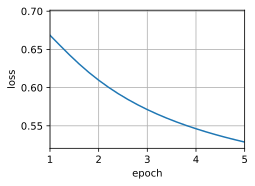

In [21]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [22]:
joblib.dump(net,"/content/drive/MyDrive/NLP/skipgramnet.pickle")

['/content/drive/MyDrive/NLP/skipgramnet.pickle']

In [23]:
def get_matrix(embed):
    Win = embed[0].weight.data
    Wout = embed[1].weight.data
    return Win, Wout

In [24]:
Win, Wout = get_matrix(net)

In [25]:
joblib.dump(Win,"/content/drive/MyDrive/NLP/Win.pickle")
joblib.dump(Wout,"/content/drive/MyDrive/NLP/Wout.pickle")

['/content/drive/MyDrive/NLP/Wout.pickle']

In [57]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [206]:
def get_analogy(token_a, token_b, token_c, W):
    vecs = W[vocab[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(W, x, 4)
    return vocab.to_tokens(topk[3:4])

In [207]:
# Test Analogies
get_analogy('patient', 'infected', 'pneumonia', Win)

'bacterial'

In [209]:
def get_similar_tokens(query_token, k, W):
    x = W[vocab[query_token]]

    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [217]:
Wavg = (Win + Wout) / 2

In [378]:
chosen_word = 'respiratory'

In [379]:
# Similarity using Win
get_similar_tokens(chosen_word, 5, Win)

cosine sim=0.988: severe
cosine sim=0.987: caused
cosine sim=0.986: these
cosine sim=0.986: laboratory
cosine sim=0.986: coronavirus


In [380]:
# Similarity using Wout
get_similar_tokens(chosen_word, 5, Wout)

cosine sim=0.989: acute
cosine sim=0.988: severe
cosine sim=0.988: sarscov
cosine sim=0.988: disease
cosine sim=0.987: less


In [381]:
# Similarity using Wavg
get_similar_tokens(chosen_word, 5, Wavg)

cosine sim=0.809: acute
cosine sim=0.802: severe
cosine sim=0.736: infections
cosine sim=0.733: coronavirus
cosine sim=0.724: disease


Wavg gives out similar words returned using Win and Wout individually which makes sense since Wavg is average of embeddings in Win and Wout.

Complexity analyses for the Skip-gram and CBOW models, as well as for the cosine similarity and analogy tasks, look largely correct with some nuances.

1. **Skip-gram (Hierarchical Softmax)**  
   - Complexity: $O(T \cdot N \cdot C \cdot \log V) $
   - Explanation: This is correct. The hierarchical softmax reduces the complexity of computing the softmax over the vocabulary $ V $ to $ O(\log V) $. So, for each target word and context word pair, the complexity is $ O(\log V) $. Given $ T $ tokens, $ N $ contexts per target word, and $ C $ as the embedding size, the total complexity is as stated.

2. **Skip-gram (Negative Sampling)**  
   - Complexity: $O(T \cdot N \cdot C \cdot k)$
   - Explanation: Correct. Negative sampling reduces the need to compute over the entire vocabulary by sampling $ k $ negative examples. Thus, for each target-context pair, the complexity is $ O(k) $. With $ T $, $ N $, and $ C $ defined as above, the complexity is as you specified.

3. **CBOW (Hierarchical Softmax)**  
   - Complexity: $O(T \cdot N \cdot C \cdot \log V) $
   - Explanation: Correct. CBOW with hierarchical softmax uses the same technique as Skip-gram for computing the output probabilities, resulting in $ O(\log V) $ per prediction. The overall complexity is the same as for Skip-gram with hierarchical softmax.

4. **CBOW (Negative Sampling)**  
   - Complexity: $O(T \cdot N \cdot C \cdot k) $
   - Explanation: Correct. Similar to Skip-gram with negative sampling, this approach reduces the complexity by only sampling $ k $ negatives, yielding the stated complexity.

5. **Cosine Similarity**  
   - Complexity: $O(N) $
   - Explanation: Correct. Cosine similarity between two vectors of dimension $ N $ requires a dot product calculation, which is $ O(N) $, as it's a single pass over the vector elements.

6. **Analogy Task**  
   - Complexity: $O(V \cdot N) $
   - Explanation: Correct. In analogy tasks, finding the best word to complete an analogy (e.g., $ a:b :: c:d $) typically involves calculating similarity scores with all words in the vocabulary $ V $. For each word, the similarity computation is $ O(N) $ (where $ N $ is the vector dimension), making the total complexity $ O(V \cdot N) $.